## Environment Setting 

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oumaed","key":"ec0ceb3590c48795749d95df4d4d9acd"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d fakhrealam9537/leaf-disease-segmentation-dataset

100% 503M/503M [00:03<00:00, 119MB/s]
100% 503M/503M [00:03<00:00, 142MB/s]


In [ ]:
# extracting data
!unzip leaf-disease-segmentation-dataset.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: aug_data/aug_data/images/00411_1.jpg  
  inflating: aug_data/aug_data/images/00411_2.jpg  
  inflating: aug_data/aug_data/images/00411_3.jpg  
  inflating: aug_data/aug_data/images/00411_4.jpg  
  inflating: aug_data/aug_data/images/00412_0.jpg  
  inflating: aug_data/aug_data/images/00412_1.jpg  
  inflating: aug_data/aug_data/images/00412_2.jpg  
  inflating: aug_data/aug_data/images/00412_3.jpg  
  inflating: aug_data/aug_data/images/00412_4.jpg  
  inflating: aug_data/aug_data/images/00413_0.jpg  
  inflating: aug_data/aug_data/images/00413_1.jpg  
  inflating: aug_data/aug_data/images/00413_2.jpg  
  inflating: aug_data/aug_data/images/00413_3.jpg  
  inflating: aug_data/aug_data/images/00413_4.jpg  
  inflating: aug_data/aug_data/images/00414_0.jpg  
  inflating: aug_data/aug_data/images/00414_1.jpg  
  inflating: aug_data/aug_data/images/00414_2.jpg  
  inflating: aug_data/aug_data/images/

### Configuration

In [ ]:
class sources:
    train = "/content/data/data/images"      
    train_mask = "/content/data/data/masks"  

## Importing Libraries

In [ ]:
import numpy as np 
import os
import cv2
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset

In [ ]:
for nom_image in os.listdir(sources.train_mask):
    img = Image.open('/content/data/data/masks/'+nom_image) 
    img = img.convert('L') 
    img.save('/content/data/data/masks/'+nom_image)

In [ ]:
sources.train_mask="/content/data/data/masks"

In [ ]:
train_img_liste = os.listdir(sources.train)
train_mask_liste = os.listdir(sources.train_mask) 

In [ ]:
print(len(train_mask_liste))
print(len(train_img_liste))

588
588


In [ ]:
print(train_mask_liste[:5])
print(train_img_liste[:5])

['00407.png', '00155.png', '00424.png', '00373.png', '00184.png']
['00274.jpg', '00496.jpg', '00250.jpg', '00332.jpg', '00330.jpg']


In [ ]:
# sorting data by labels
sorted_train_mask_liste = sorted(train_mask_liste)  
sorted_train_img_liste = sorted(train_img_liste)

In [ ]:
# images and masks sorted
print(sorted_train_mask_liste[:16])
print(sorted_train_img_liste[:16])

['00000.png', '00001.png', '00002.png', '00003.png', '00004.png', '00005.png', '00006.png', '00007.png', '00008.png', '00009.png', '00010.png', '00011.png', '00012.png', '00013.png', '00014.png', '00015.png']
['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg']


/content/data/data/images/00000.jpg
(326, 235)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


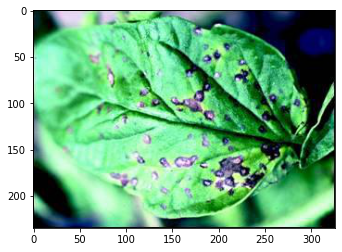

/content/data/data/masks/00000.png
(326, 235)


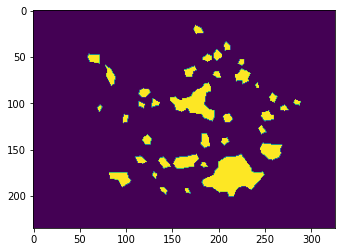

----------------------------------------------------
/content/data/data/images/00001.jpg
(326, 234)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


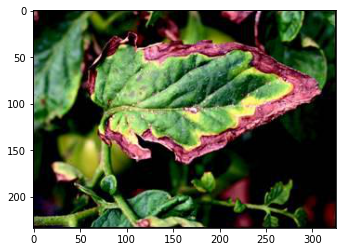

/content/data/data/masks/00001.png
(326, 234)


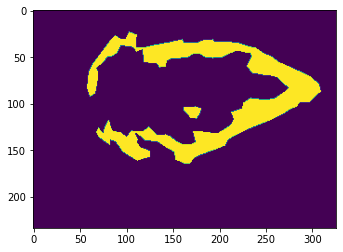

----------------------------------------------------


In [ ]:
# Visualisation 
def afficher_images(imgs_liste,masks_liste,boucles=2):
    for i in range(boucles):
        img_chemain = os.path.join(sources.train,imgs_liste[i])
        mask_chemain = os.path.join(sources.train_mask,masks_liste[i])
        img = Image.open(img_chemain)
        mask = Image.open(mask_chemain)
        print(img_chemain)
        print(img.size)
        print(type(img))
        plt.imshow(img)
        plt.show()
        print(mask_chemain)
        print(mask.size)
        plt.imshow(mask)
        plt.show()
        print("----------------------------------------------------")

afficher_images(sorted_train_img_liste, sorted_train_mask_liste)

In [ ]:
# configuring model's parameters
class CFG:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    split_pct = 0.2
    learning_rate = 3e-4
    batch_size = 4
    epochs = 30

In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
CFG.device

device(type='cuda')

In [ ]:
print(sorted_train_img_liste[:5])
print(sorted_train_mask_liste[:5])

['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg']
['00000.png', '00001.png', '00002.png', '00003.png', '00004.png']


/content/data/data/images/00000.jpg
(326, 235)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


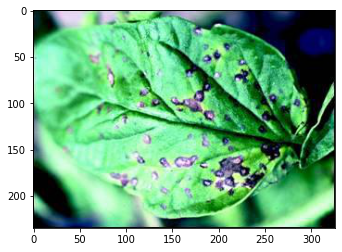

/content/data/data/masks/00000.png
(326, 235)


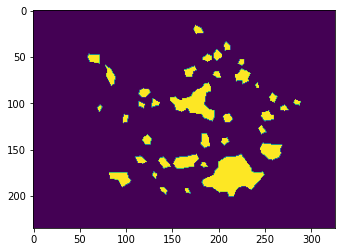

----------------------------------------------------
/content/data/data/images/00001.jpg
(326, 234)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


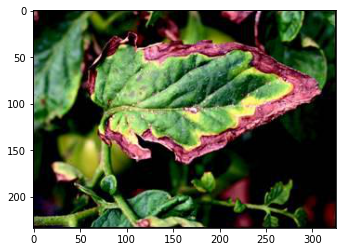

/content/data/data/masks/00001.png
(326, 234)


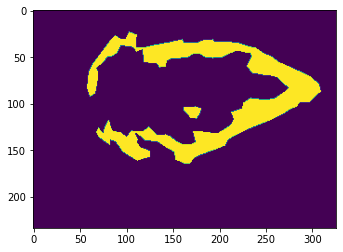

----------------------------------------------------


In [ ]:
afficher_images(sorted_train_img_liste,sorted_train_mask_liste)

In [ ]:
train_images_list = sorted_train_img_liste[int(CFG.split_pct*len(sorted_train_img_liste)) :]
train_masks_list = sorted_train_mask_liste[int(CFG.split_pct*len(sorted_train_mask_liste)) :]
print(len(train_masks_list))

val_images_list = sorted_train_img_liste[: int(CFG.split_pct*len(sorted_train_img_liste))]
val_masks_list = sorted_train_mask_liste[: int(CFG.split_pct*len(sorted_train_mask_liste))]
print(len(val_masks_list))

471
117


/content/data/data/images/00117.jpg
(257, 348)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


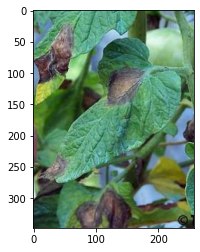

/content/data/data/masks/00117.png
(257, 348)


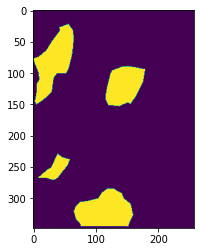

----------------------------------------------------
/content/data/data/images/00118.jpg
(269, 271)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


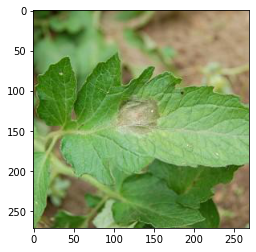

/content/data/data/masks/00118.png
(269, 271)


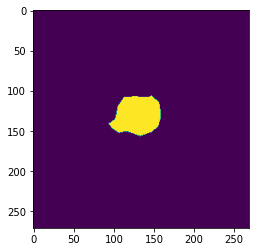

----------------------------------------------------


In [ ]:
# Let's visualize training data
afficher_images(train_images_list,train_masks_list)

/content/data/data/images/00000.jpg
(326, 235)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


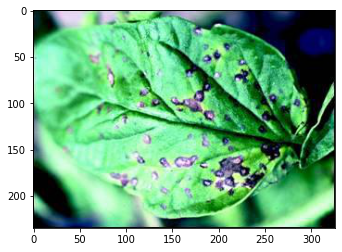

/content/data/data/masks/00000.png
(326, 235)


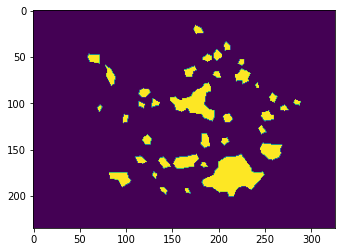

----------------------------------------------------
/content/data/data/images/00001.jpg
(326, 234)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


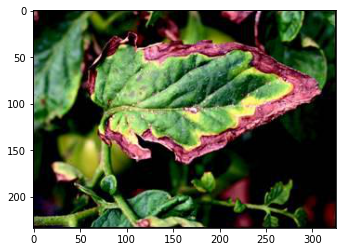

/content/data/data/masks/00001.png
(326, 234)


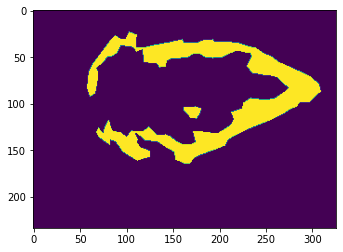

----------------------------------------------------


In [ ]:
afficher_images(val_images_list,val_masks_list) # validation set data

In [ ]:
class CarvanaDataset(Dataset):
    def __init__(self,img_list,mask_list,transform=None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,index):
        img_path = os.path.join(sources.train,self.img_list[index])
        mask_path = os.path.join(sources.train_mask,self.mask_list[index])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255.0] = 1.0
        
        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask,0)
            
        return img,mask

In [ ]:
train_transform = A.Compose([A.Resize(572,572), 
                             A.Rotate(limit=15,p=0.1),
                             A.HorizontalFlip(p=0.5),
                             A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(572,572),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

In [ ]:
train_dataset = CarvanaDataset(train_images_list, train_masks_list, transform = train_transform)
val_dataset = CarvanaDataset(val_images_list, val_masks_list, transform = train_transform)

In [ ]:
idx = 200
img,mask = train_dataset[idx]

In [ ]:
mask.shape

torch.Size([1, 572, 572])

In [ ]:
img.max()

tensor(0.9961)

In [ ]:
train_dataloader = DataLoader(train_dataset,batch_size=CFG.batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=CFG.batch_size,shuffle=False)

In [ ]:
a = iter(train_dataloader)
img,mask = next(a)
print(img.shape, mask.shape)

torch.Size([4, 3, 572, 572]) torch.Size([4, 1, 572, 572])


In [ ]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv
    
def padder(left_tensor, right_tensor): 
    
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(CFG.device)
    
    return right_tensor.to(CFG.device)

### UNET model for segmentation

In [ ]:
class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)
        
        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)
        
    def forward(self,x):

        # encoding
        x1 = self.down_conv_1(x)
        p1 = self.max_pool(x1)
        x2 = self.down_conv_2(p1)
        p2 = self.max_pool(x2)
        x3 = self.down_conv_3(p2)
        p3 = self.max_pool(x3)
        x4 = self.down_conv_4(p3)
        p4 = self.max_pool(x4)
        x5 = self.down_conv_5(p4)
        
        # decoding
        d1 = self.up_conv_trans_1(x5)  
        pad1 = padder(x4,d1) 
        cat1 = torch.cat([x4,pad1],dim=1) 
        uc1 = self.up_conv_1(cat1) 
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)
        
        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1

In [ ]:
# definition of the training evaluation function
def train_model(model, dataloader, criterion, optimizer):
    model.train()
    train_running_loss = 0.0
    for j,img_mask in enumerate(tqdm(dataloader)):
        img = img_mask[0].float().to(CFG.device)

        mask = img_mask[1].float().to(CFG.device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        
        loss = criterion(y_pred,mask)
        
        train_running_loss += loss.item() * CFG.batch_size
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / (j+1)
    return train_loss

In [ ]:
# definition of the validation evaluation function
def val_model(model,dataloader,criterion,optimizer):
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for j,img_mask in enumerate(tqdm(dataloader)):
            img = img_mask[0].float().to(CFG.device)
            mask = img_mask[1].float().to(CFG.device)
            y_pred = model(img)
            loss = criterion(y_pred,mask)
            
            val_running_loss += loss.item() * CFG.batch_size
            
        val_loss = val_running_loss / (j+1)
    return val_loss

In [ ]:
model = UNET(in_chnls = 3, n_classes = 1).to(CFG.device)
optimizer = optim.Adam(model.parameters(), lr = CFG.learning_rate)
criterion = nn.BCEWithLogitsLoss()
train_loss_lst = []
val_loss_lst = [] 

###  Training the model

In [ ]:
for i in tqdm(range(CFG.epochs)):
    train_loss = train_model(model=model,dataloader=train_dataloader,criterion=criterion,optimizer=optimizer)
    val_loss = val_model(model=model,dataloader=val_dataloader,criterion=criterion,optimizer=optimizer)
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)
    print(f" Train Loss : {train_loss:.4f}")
    print(f" Validation Loss : {val_loss:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -57.4116
 Validation Loss : -124.8365


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -106.8980
 Validation Loss : -233.2483


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -160.9982
 Validation Loss : -376.1291


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -235.8222
 Validation Loss : -185.3518


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -324.0671
 Validation Loss : -308.9057


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -416.6795
 Validation Loss : -153.0537


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -535.0389
 Validation Loss : -668.7190


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -663.0282
 Validation Loss : -708.9778


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -792.7331
 Validation Loss : -1535.9702


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -936.8757
 Validation Loss : -1546.9025


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -1088.3110
 Validation Loss : -1169.8855


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -1250.0438
 Validation Loss : -1562.7041


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -1425.1404
 Validation Loss : -1511.4723


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -1596.8364
 Validation Loss : -2852.8435


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -1796.8641
 Validation Loss : -2396.0005


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -1999.4282
 Validation Loss : -2262.9422


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -2232.3387
 Validation Loss : -2548.0019


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -2445.5318
 Validation Loss : -1718.3496


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -2734.5757
 Validation Loss : -2786.1751


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -2960.3603
 Validation Loss : -3101.1334


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -3212.7569
 Validation Loss : -3131.0672


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -3448.7745
 Validation Loss : -2575.6430


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -3652.9929
 Validation Loss : -4082.7089


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -3995.6614
 Validation Loss : -4051.1677


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -4218.6795
 Validation Loss : -4165.2122


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -4531.1774
 Validation Loss : -5326.1798


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -4850.4870
 Validation Loss : -5207.0961


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -5238.7484
 Validation Loss : -5324.7795


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -5565.2191
 Validation Loss : -5533.8359


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Train Loss : -5800.7537
 Validation Loss : -4489.1973


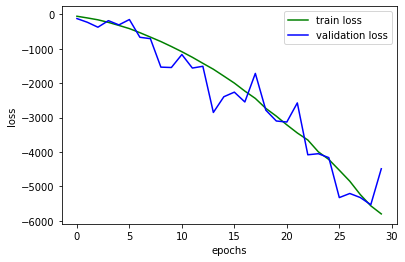

In [ ]:
# Learning curve
plt.plot(train_loss_lst, color="green", label='train loss')
plt.plot(val_loss_lst, color="blue", label='validation loss')

plt.title("Learning curve")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
# saving the model
torch.save(model.state_dict(), "/content/unet_scratch.pth")

### Teste

In [ ]:
trained_model = UNET(in_chnls = 3, n_classes = 1)

In [ ]:
UNET_TRAINED = "/content/unet_scratch.pth"

In [ ]:
trained_model.load_state_dict(torch.load(UNET_TRAINED))

<All keys matched successfully>

In [ ]:
trained_model = trained_model.to("cuda")
trained_model.eval()

UNET(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=

In [ ]:
img_path = "/content/data/data/images/00028.jpg"
img = cv2.imread(img_path)

In [ ]:
mask_path = "/content/data/data/masks/00028.png"
mask = cv2.imread(mask_path)

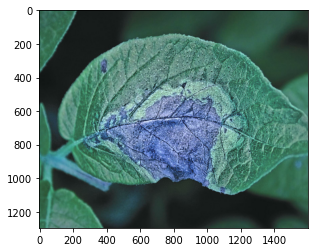

In [ ]:
plt.imshow(img)
plt.show()

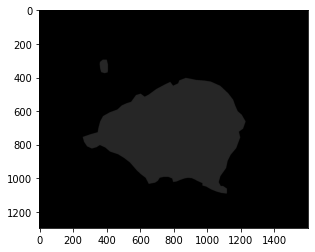

In [ ]:
plt.imshow(mask)
plt.show()

In [ ]:
test_transform = A.Compose([A.Resize(572,572),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

In [ ]:
test_image = test_transform(image = img)

print(test_image)

print(test_image["image"].dtype)
print(test_image["image"].shape)

img = test_image["image"].unsqueeze(0)
print(img.shape)

img = img.to("cuda")

{'image': tensor([[[0.2078, 0.2000, 0.2000,  ..., 0.1608, 0.1569, 0.1529],
         [0.2039, 0.2157, 0.1922,  ..., 0.1608, 0.1569, 0.1529],
         [0.2000, 0.2157, 0.1922,  ..., 0.1608, 0.1569, 0.1529],
         ...,
         [0.2157, 0.2235, 0.2196,  ..., 0.1765, 0.1686, 0.1608],
         [0.2275, 0.2275, 0.2157,  ..., 0.1725, 0.1765, 0.1686],
         [0.2275, 0.2314, 0.2235,  ..., 0.1804, 0.1843, 0.1804]],

        [[0.4235, 0.4078, 0.4039,  ..., 0.2275, 0.2235, 0.2196],
         [0.4157, 0.4235, 0.3961,  ..., 0.2275, 0.2235, 0.2196],
         [0.4118, 0.4235, 0.3961,  ..., 0.2275, 0.2235, 0.2196],
         ...,
         [0.4431, 0.4510, 0.4471,  ..., 0.3176, 0.3059, 0.2941],
         [0.4549, 0.4549, 0.4431,  ..., 0.3216, 0.3176, 0.3098],
         [0.4549, 0.4588, 0.4510,  ..., 0.3294, 0.3255, 0.3216]],

        [[0.3333, 0.3176, 0.3137,  ..., 0.1843, 0.1804, 0.1765],
         [0.3255, 0.3333, 0.3059,  ..., 0.1843, 0.1804, 0.1765],
         [0.3216, 0.3333, 0.3098,  ..., 0.1843, 

In [ ]:
pred = trained_model(img)
pred.shape

torch.Size([1, 1, 572, 572])

In [ ]:
mask = pred.squeeze(0).cpu().detach().numpy()
print(mask.shape)
mask = mask.transpose(1,2,0)
print(mask.shape)

(1, 572, 572)
(572, 572, 1)


In [ ]:
display_test_img = test_image["image"].cpu().detach().numpy()
print(display_test_img.shape)
display_test_img = display_test_img.transpose(1,2,0)
display_test_img.shape

(3, 572, 572)


(572, 572, 3)

In [ ]:
mask[mask < 0]=0
mask[mask > 0]=1

-------Original Image-------


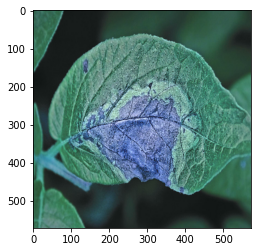

In [ ]:
print("-------Original Image-------")
plt.imshow(display_test_img, cmap="gray")
plt.show()